# Example 4 -- Voronoi Grid

In [1]:
# import Python packages used for this example
import pathlib as pl
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, LineString
import flopy
import flopy.utils.triangle
import flopy.utils.voronoi

In [2]:
# set up paths
ws = './ex4'
name = 'mymodel'
triangle_ws = pl.Path(ws, "triangle")
triangle_ws.mkdir(parents=True, exist_ok=True)

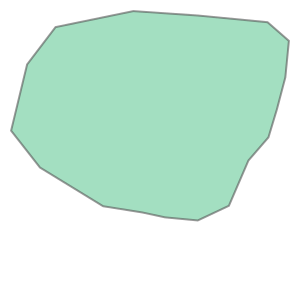

In [3]:
# define the model domain using a shapely Polygon
domain = Polygon([
    [1831.38, 6335.54],
    [4337.73, 6851.13],
    [6428.74, 6707.91],
    [8662.98, 6493.08],
    [9350.43, 5891.56],
    [9235.86, 4717.15],
    [8963.74, 3685.97],
    [8691.62, 2783.68],
    [8047.13, 2038.94],
    [7416.96, 578.09],
    [6414.42, 105.46],
    [5354.59, 205.72],
    [4624.17, 363.26],
    [3363.83, 563.77],
    [1330.11, 1809.78],
    [399.18, 2998.51],
    [914.77, 5132.49],
])
domain

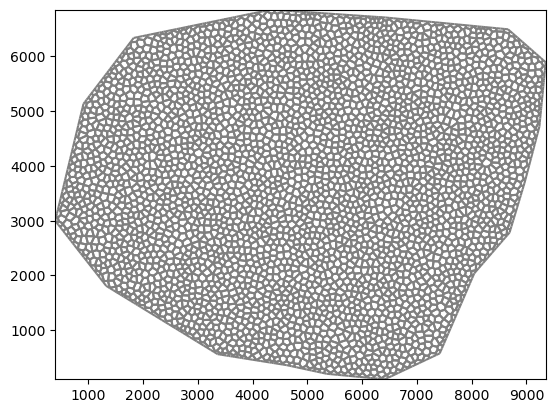

In [4]:
# Create a voronoi grid
area_max = 1. * 100.0**2
tri = flopy.utils.triangle.Triangle(maximum_area=area_max, angle=30, model_ws=triangle_ws)
tri.add_polygon(domain)
tri.build(verbose=False)
vor = flopy.utils.voronoi.VoronoiGrid(tri)
vg_gridprops = vor.get_gridprops_vertexgrid()
vg = flopy.discretization.VertexGrid(**vg_gridprops)
vg.plot()

In [5]:
# set constant heads around domain
gi = flopy.utils.GridIntersect(vg)
ls = LineString([p for p in domain.exterior.coords])
chdspd = [[(0, j), 1.] for j in np.array(gi.intersects(ls)["cellids"], dtype=int)]

In [6]:
# create the flopy representation of the MODFLOW simulation
top = 50.
botm = [-100.]
nlay = 1
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim, print_option="all", inner_maximum=100)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
disv = flopy.mf6.ModflowGwfdisv(
    gwf, nlay=nlay, **vor.get_disv_gridprops(), top=top, botm=botm)
ic = flopy.mf6.ModflowGwfic(gwf, strt=top)
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True, icelltype=1)
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdspd)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.001)
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=f"{name}.bud",
                            head_filerecord=f"{name}.hds",
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

In [7]:
# write the MODFLOW input files
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 181 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...


In [8]:
# run the MODFLOW simulation
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:29:14 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor

(True, [])

In [9]:
# load the output from the simulation
head = gwf.output.head().get_data()
bud = gwf.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

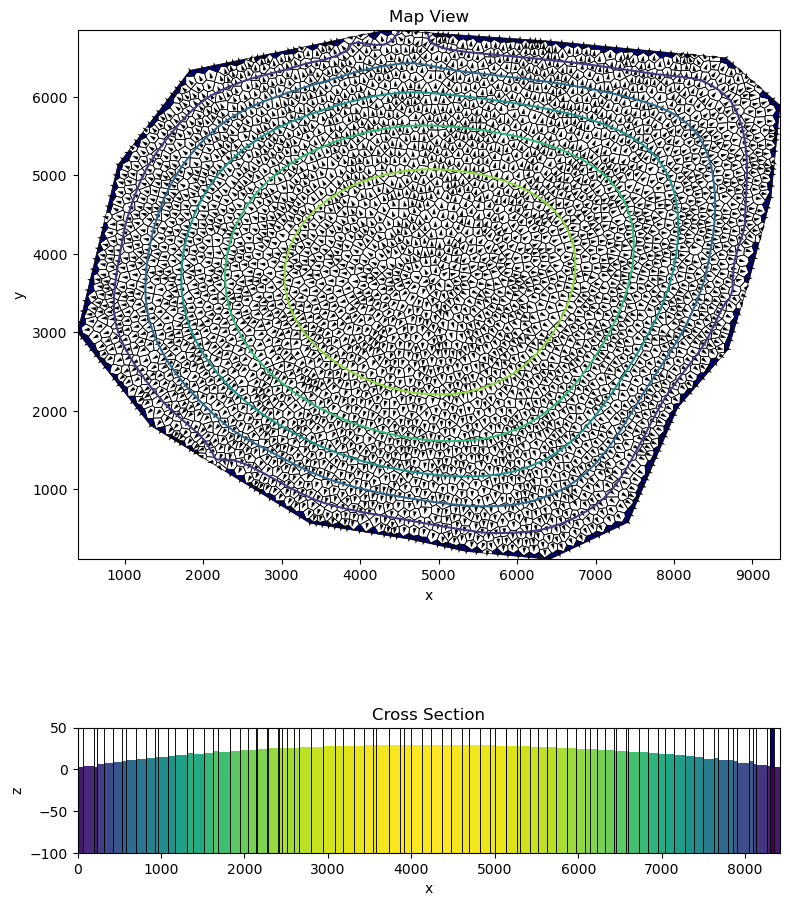

In [10]:
# create a plot of the model results
fig, axes = plt.subplots(2, 1, figsize=(8, 11))
ax = axes[0]
ax.set_title("Map View")
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
pmv.plot_bc(ftype="CHD")
pmv.plot_grid(color="black", linewidth=0.5)
#pmv.plot_array(head)
pmv.plot_vector(qx, qy, normalize=True, color="black", istep=1, jstep=1)
pmv.contour_array(head)

ax = axes[1]
ax.set_title("Cross Section")
ax.set_aspect(10.)
ax.set_xlabel("x")
ax.set_ylabel("z")
pxs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"line": [(0, 4500), (9500, 4500)]})
pxs.plot_bc(ftype="CHD")
pxs.plot_array(head, head=head)
pxs.plot_grid(color="black", linewidth=0.5)
plt.tight_layout()